# Time Series - II (AR Models)

An Auto Regressive (AR) model is a regression which depends linearly on the previous terms. An auto regressive model of order p is a regression model that linearly depends on p previous terms.

$x_{t}$ = $a_{1}$ $x_{t-1}$ + ... + $a_{p}$ $x_{t-p}$ + $w_{t}$

In the above equation, p represents the number of previous terms (lags) used in the model, a is the regressive coefficient and w is the white noise in the term which cannot be explained with the help of previous terms.

In [1]:
#Importing the required packages

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Defining a function to visualize and analyze the time series 

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    '''
    Prepares a (3,2) dimensional plot for the visualization of time series values, autocorrelation and partial 
    autocorrelation plots and QQ and probability plots for comparision with normal distribution.
    
    Args:
    y: time series values
    lags: How many lagging values are to be considered.
    '''
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)

        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

**Simulating AR(1) process with a = 0.6 **

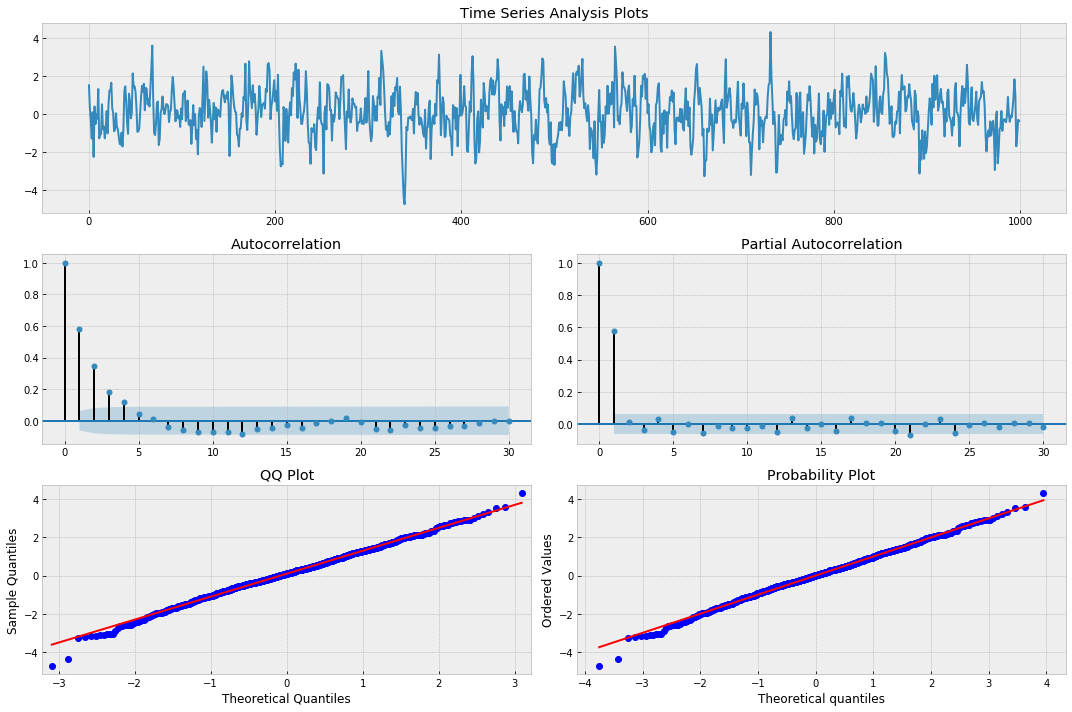

In [3]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30)

The distribution of our sampled AR1 model data is normal, as it should be as we sampled the data from normal distribution. There is significant correlation between lagged values visible in the ACF plot. 

PACF plots are used to identify the extent of the lag in an autoregressive mode. If we find no significant correlation in a PACF plot after lag $k$, an AR(k) model is usually a good fit. Looking at this chart, we can hypothesize that a AR(1) model should fit.

**Fitting data with Python's statsmodels package **

Now we will use python's statsmodels packages and try to fit an AR model on the data we obtained in the last step to estimate the alpha coefficient and order.

In [4]:
model = sm.tsa.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = sm.tsa.AR(x).select_order( maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: %3.5f | order_estimate %s'%(model.params, est_order))
print('\ntrue alpha = %s | true order = %s'%(a, true_order))


alpha estimate: 0.58227 | order_estimate 1

true alpha = 0.6 | true order = 1


Using statsmodels packages, we have found the value of alpha very near to that of its real value used to generate the data. Also, we were able to identify the order of the AR model accurately.


**Simulating AR(2) process with $a_{1}$ = 0.666 and $a_{2}$ = -0.333**

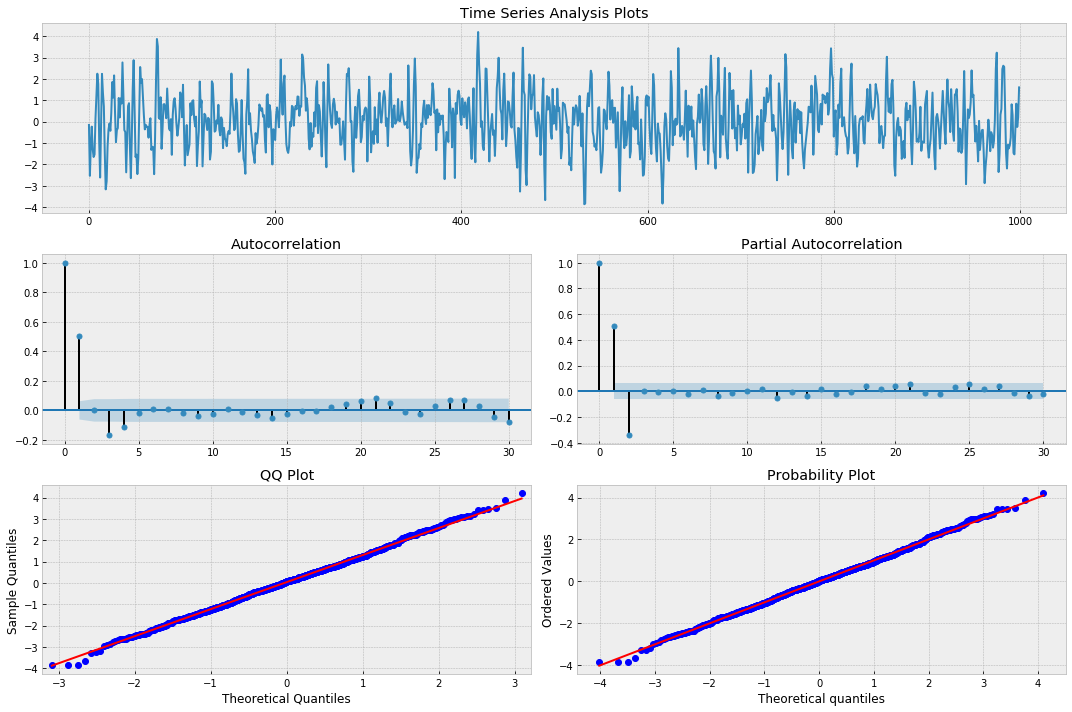

In [5]:
n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=30)

In [6]:
#Fitting the model
max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order( maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: %3.4f %3.4f | order estimate %s'%(mdl.params[0],mdl.params[1],est_order))


coef estimate: 0.6760 -0.3393 | order estimate 2


In the above models, we are explicitly choosing a lag of 10. If we don't specify the maximum lag that we want to consider, then the model will itself try to estimate the lags. In this process, we will end with estimating many more lags than the actual case because of indirect dependencies (see below). For Example, our AR(1) model just depends on the previous value $x_{t}$ (lag = 1), but model will include many more lags as $x_{t}$ depends on $x_{t-1}$ and in turn $x_{t-2}$ and so on indirectly.

This inclusion of indirect dependencies is not a good thing, as we want to have as few parameters in the model as possible. Including all the parameters overfit the data. 

### Naive fit of the model

Fitting a model naively will estimate a lot of parameters. In the below model on AR(2) data, the model estimates a lot of parameters/lags due to indirect dependencies as discussed above.

In [14]:
model2 = smt.AR(ar2).fit()
print('Parameters')
print(model2.params)
print('Standard Error')
print(model2.bse)

Parameters
[ 3.57345632e-02  6.67118523e-01 -3.40041205e-01  9.01909128e-03
 -1.11520048e-02  2.14435279e-02 -4.83381895e-02  3.28287551e-02
 -2.38531001e-02 -4.90031065e-04 -3.12735473e-02  5.21112625e-02
 -5.85303137e-02  2.17108859e-02 -5.58739239e-02  2.79663351e-02
 -6.45697812e-03 -2.90269682e-02  3.79624698e-02  1.12370300e-02
  2.54545125e-03  5.79634021e-02]
Standard Error
[0.03330767 0.03229192 0.03882052 0.04032568 0.04032737 0.04031148
 0.04030305 0.04029053 0.04027444 0.04025271 0.04022384 0.04018031
 0.0402171  0.04026555 0.04027908 0.04028844 0.04027529 0.04028007
 0.04028697 0.04034915 0.03870137 0.03212717]


By observing the ACF and PACF plots, we can infer that first two lags are useful. We can also AIC (Akaike Information Criterion) to test the useful lags. Python does that for usu when we use 'maxlags' and 'ic' arguments in the fit() function.  We want a model with smallest AIC, so we compute the AIC for all the models that we want to consider and we select the model with the smallest AIC. This model minimizes the information loss and select the best number of parameters.


In [7]:
N = 10
AIC = np.zeros((N,1))

for i in range(N):
    model = smt.AR(ar2)
    model = model.fit(maxlag = (i+1))
    AIC[i] = model.aic

AIC_min = np.min(AIC)
model_min = np.argmin(AIC)

print("Minimum number of parameters in minimum AIC model %s" %(model_min + 1))

Minimum number of parameters in minimum AIC model 2


**Evaluating Residuals **

The final step after fitting the model is to evaluate its residual behaviour. We want out residuals to be white noise because if it is not then that means there is still some pattern in it which could be extracted and there is a scope of making our model better.

The residuals seem normally distributed.


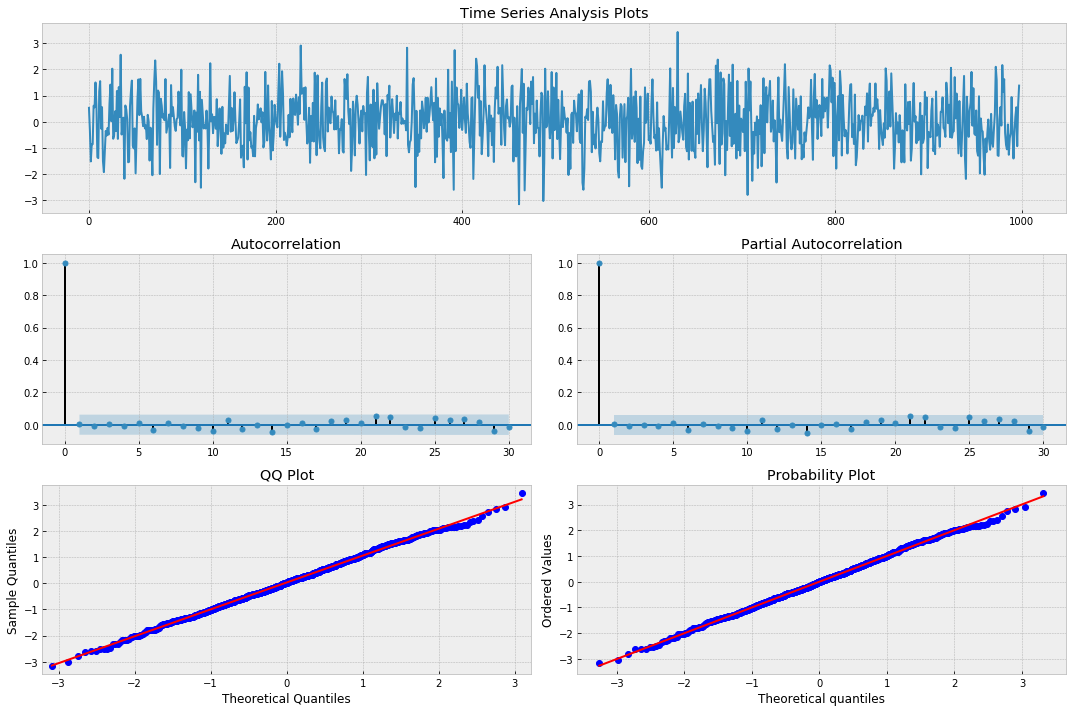

In [8]:
# Checking the normality of the residuals

from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')
    
tsplot(mdl.resid, lags=30)

The residuals looks like randomly distributed in the above plots, indicating that the model explains the data well.

## Application of the above principles

In this section, we apply the above technique on the log returns of TSLA (Tesla Inc.) stock data and see how good can we explain the changes. We use last 5 years EOD stock price data of the TSLA stock which could be downloaded from Yahoo Finance.

**What are Log returns? ** 

Rate of Return is profit on an investment or a particular stock over a period of time, expressed as a proportion of the original investment. We use rate of return instead of absolute difference of the stock price in order to normalize the return with respect to the stock price. Log returns or Logarithmic rate of return is the log of the return for two dates.

For Example, if a stock is priced at 3.570 USD per share at the close on one day, and at 3.575 USD per share at the close the next day, then the logarithmic return is: ln(3.575/3.570) = 0.0014, or 0.14%

There are multiple reasons to work with log returns and this blog post summarizes everything beautifully: https://quantivity.wordpress.com/2011/02/21/why-log-returns/


In [9]:
#Downloading the data from the directory

tsla_market_data = pd.read_csv("C:\\Users\ku.kulshrestha\Downloads\TSLA.csv")
print(tsla_market_data.head(5))

         Date        Open        High         Low       Close   Adj Close  \
0  2013-06-20  104.650002  107.129997   99.449997  100.650002  100.650002   
1  2013-06-21  103.699997  103.699997   97.500000   99.550003   99.550003   
2  2013-06-24   96.500000  102.870003   95.300003  101.489998  101.489998   
3  2013-06-25  103.099998  104.199997  100.550003  102.400002  102.400002   
4  2013-06-26  103.800003  105.870003  102.660004  105.720001  105.720001   

     Volume  
0  10106500  
1  11718600  
2   7119800  
3   5848700  
4   6602600  


Since we would only be dealing with the price at the end of the day, hence we only need to take care about Close column of the above dataset and then calculate the log returns of the closing price.

In [10]:
tsla_ts_data = tsla_market_data[['Date', 'Close']]

#Adding a new col in the dataframe
tsla_ts_data['Log_return'] = np.nan
tsla_ts_data.head()
for i in range(1, len(tsla_ts_data)):
    tsla_ts_data.loc[i, 'Log_return'] = np.log(np.divide(tsla_ts_data.loc[i,'Close'], tsla_ts_data.loc[i-1, 'Close'])) 

#removing the first row as Log_return cannot be defined for it
tsla_ts_data = tsla_ts_data.dropna()
tsla_ts_data.head()

,Date,Close,Log_return
1,2013-06-21,99.550003,-0.010989
2,2013-06-24,101.489998,0.019300
3,2013-06-25,102.400002,0.008926
4,2013-06-26,105.720001,0.031907
5,2013-06-27,109.250000,0.032845


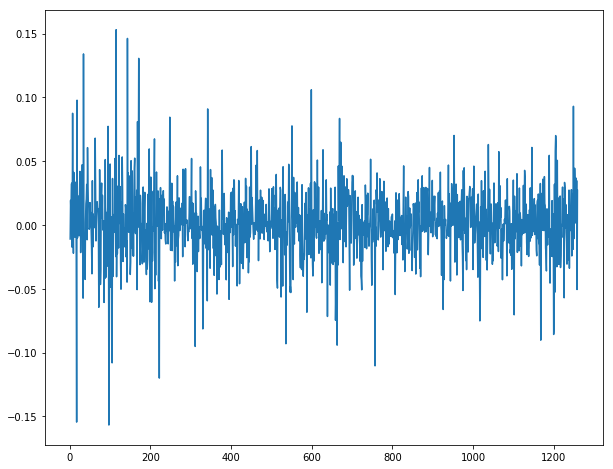

In [11]:
#Plotting the distribution of the log returns
tsla_ts_data.Log_return.plot(figsize = (10,8))

Now we have our data ready, we will try to fit a simple AR(p) model on the Log_return data, find out the best order and plot the residuals of the model.

best estimated lag order = 1


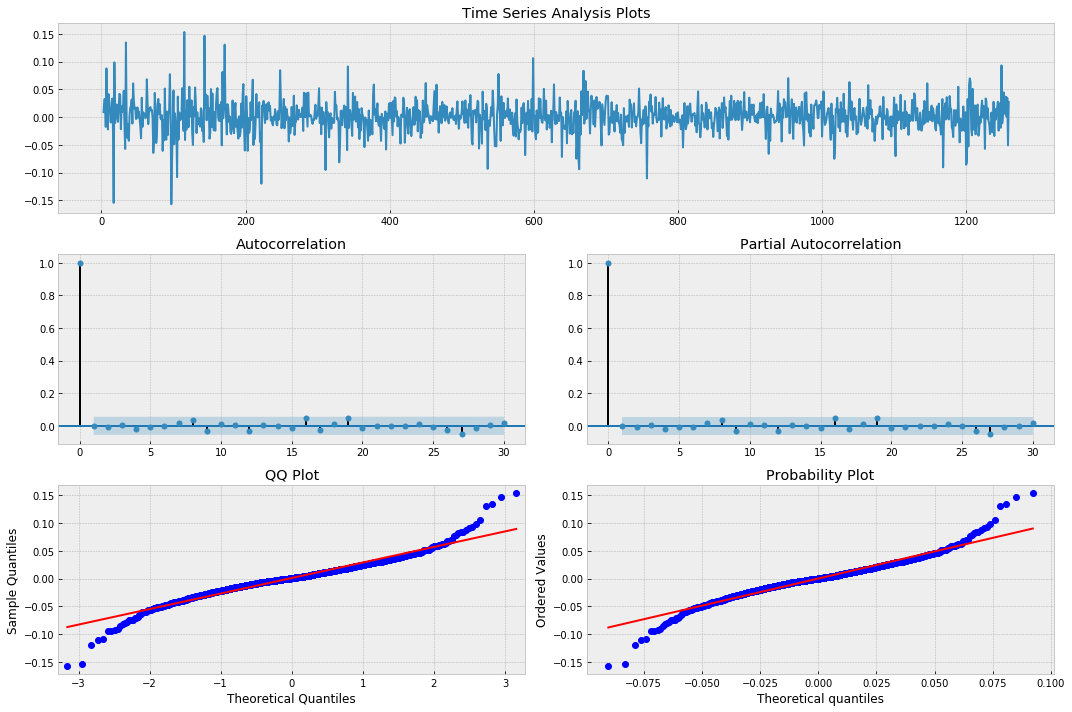

In [12]:
max_lag = 30
mdl = smt.AR(tsla_ts_data.Log_return.iloc[1:]).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(tsla_ts_data.Log_return.iloc[1:]).select_order(maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = %s'%(est_order))

_ = tsplot(mdl.resid, lags=max_lag)

This study suggests us that AR(1) model best explains the data. There are also some non significant peaks on 16th and 19th lags on the PACF plot of the residuals. This indicates that there is probability more complexity in the data hidden which our simple linear model is not able to explain.

Below test of normality of the residuals also confirms the same.

In [13]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

print('Score is: ', score)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

Score is:  1006.8068128169832
We have reason to suspect the residuals are not normally distributed.


Jarque Bera test is generally used to check for the normality of the data. A gentle introduction for the same can be found here: http://www.statisticshowto.com/jarque-bera-test/